In [1]:
#Importing packages
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Input the processed CRM data
santander_crm = pd.read_csv("Data/Processed/One_but_last_month_data_processsed.csv")

In [3]:
santander_crm = santander_crm[santander_crm['no_of_accounts'] > 1]

### Rule Based Segmentation

In [4]:
list(santander_crm)

['customer_code',
 'sex',
 'age',
 'new_customer_index',
 'seniority',
 'customer_relation_at_begin',
 'foreign_index',
 'province_name',
 'activity_index',
 'gross_income',
 'segmentation',
 'ind_savings_account',
 'ind_guarantees',
 'ind_current_account',
 'ind_derivada_account',
 'ind_payroll_account',
 'ind_junior_account',
 'ind_mas_particular_account',
 'ind_particular_account',
 'ind_particular_plus_account',
 'ind_short_term_deposit',
 'ind_medium_term_deposit',
 'ind_long_term_deposit',
 'ind_eaccount',
 'ind_funds',
 'ind_mortgage',
 'ind_loans',
 'ind_taxes',
 'ind_credit_cards',
 'ind_securities',
 'ind_home_accounts',
 'ind_pensions_2',
 'ind_direct_debits',
 'province_segment',
 'no_of_accounts']

In [5]:
#Rename segmentation column as customer_type
santander_crm.columns = santander_crm.columns.str.replace('segmentation', 'customer_type')

In [6]:
#Define rules to bin continuous variables : age, gross_income, seniority and no_of_accounts

santander_crm = santander_crm.assign(age_bin = pd.qcut(santander_crm['age'],q=3,duplicates='drop',labels=[0,1,2]))
santander_crm = santander_crm.assign(inc_bin = pd.qcut(santander_crm['gross_income'],q=3,duplicates='drop',labels=[0,1,2]))
santander_crm = santander_crm.assign(sen_bin = pd.qcut(santander_crm['seniority'],q=3,duplicates='drop',labels=[0,1,2]))
santander_crm = santander_crm.assign(naccount_bin = pd.cut(santander_crm['no_of_accounts'],bins=[1,4,7,pd.np.inf],duplicates='drop',labels=[0,1,2]))

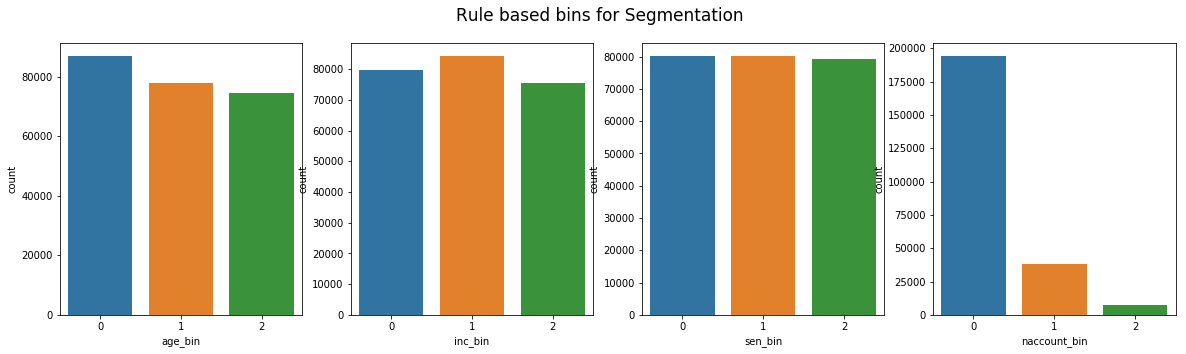

In [7]:
#Check the distribution of created bins for 
f, axes = plt.subplots(1, 4,figsize=(20,5))
plt.suptitle('Rule based bins for Segmentation', fontsize=17)
sns.countplot(santander_crm['age_bin'],ax=axes[0])
sns.countplot(santander_crm['inc_bin'],ax=axes[1])
sns.countplot(santander_crm['sen_bin'],ax=axes[2])
sns.countplot(santander_crm['naccount_bin'],ax=axes[3])

##### Creaating segments data based on rules

In [8]:
#Segment customers based on age
seg_age_low = santander_crm[santander_crm['age_bin'] == 0]
seg_age_med = santander_crm[santander_crm['age_bin'] == 1]
seg_age_high = santander_crm[santander_crm['age_bin'] == 2]

In [9]:
#Segment customers based on income
seg_inc_low = santander_crm[santander_crm['inc_bin'] == 0]
seg_inc_med = santander_crm[santander_crm['inc_bin'] == 1]
seg_inc_high = santander_crm[santander_crm['inc_bin'] == 2]

In [10]:
#Segment customers based on seniority
seg_sen_low = santander_crm[santander_crm['sen_bin'] == 0]
seg_sen_med = santander_crm[santander_crm['sen_bin'] == 1]
seg_sen_high = santander_crm[santander_crm['sen_bin'] == 2]

In [11]:
#Segment customers based on number of accounts
seg_nacc_low = santander_crm[santander_crm['naccount_bin'] == 0]
seg_nacc_med = santander_crm[santander_crm['naccount_bin'] == 1]
seg_nacc_high = santander_crm[santander_crm['naccount_bin'] == 2]

In [12]:
#Segment customers based on activity index
seg_active = santander_crm[santander_crm['activity_index'] == 1]
seg_inactive = santander_crm[santander_crm['activity_index'] == 0]

In [13]:
#Segment customers based on foreign index
seg_foreign_no = santander_crm[santander_crm['foreign_index'] == 'N']
seg_foreign_yes = santander_crm[santander_crm['foreign_index'] == 'S']

In [14]:
#Segment customers based on new_customer_index
seg_newcust_no = santander_crm[santander_crm['new_customer_index'] == 0]
seg_newcust_yes = santander_crm[santander_crm['new_customer_index'] == 1]

In [15]:
#Segment customers based on customer type
seg_vip = santander_crm[santander_crm['customer_type'] == 'VIP']
seg_ind = santander_crm[santander_crm['customer_type'] == 'INDIVIDUALS']
seg_uni = santander_crm[santander_crm['customer_type'] == 'UNIVERSITY']

### Function to create the transaction data for MBA

In [16]:
list_columns = list(santander_crm)
list_accounts = list_columns[11:33]
list_accounts.append('customer_code')

In [17]:
def maketrans(transactions):
    transactions_filter = transactions[list_accounts]
    transactions_filter=transactions_filter.set_index('customer_code')
    return transactions_filter

### MBA for Age segments

In [18]:
#Create transactions for age segments
seg_age_low_trans = maketrans(seg_age_low)
seg_age_med_trans = maketrans(seg_age_med)
seg_age_high_trans = maketrans(seg_age_high)

In [19]:
#Low Age Segment
frequent_itemsets = apriori(seg_age_low_trans, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets[frequent_itemsets.itemsets.map(len)<3]
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules['chisq'] = ''
rules['pvalue'] = ''
for i in range(0,len(rules)):
    if not ((rules['support'][i] == rules['confidence'][i]) or (rules['lift'][i] == rules['confidence'][i])):
        a=len(seg_age_low)
        b=(rules['lift'][i]-1)**2
        c=(rules['support'][i])*(rules['confidence'][i])
        d=(rules['confidence'][i] - rules['support'][i])
        e=(rules['lift'][i]-rules['confidence'][i])
        rules['chisq'][i] = ((a*b*c)/(d*e))
        rules['pvalue'][i] = 1-(stats.chi2.cdf(rules['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules = rules[rules['pvalue'] < 0.05]
rules['lift']=round(rules['lift'],5)
rules.sort_values(by=['lift', 'antecedent support'], ascending = [False,False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
9,(ind_payroll_account),(ind_pensions_2),0.335291,0.250244,0.234095,0.698183,2.79001,0.150190,2.484141,46930.9,0
8,(ind_pensions_2),(ind_payroll_account),0.250244,0.335291,0.234095,0.935465,2.79001,0.150190,10.299911,46930.9,0
20,(ind_taxes),(ind_credit_cards),0.161737,0.110013,0.038598,0.238647,2.16927,0.020805,1.168955,2836.81,0
21,(ind_credit_cards),(ind_taxes),0.110013,0.161737,0.038598,0.350852,2.16927,0.020805,1.291326,2836.81,0
12,(ind_taxes),(ind_particular_plus_account),0.161737,0.089208,0.027437,0.169640,1.90162,0.013009,1.096864,1336.53,0
13,(ind_particular_plus_account),(ind_taxes),0.089208,0.161737,0.027437,0.307563,1.90162,0.013009,1.210598,1336.53,0
25,(ind_pensions_2),(ind_credit_cards),0.250244,0.110013,0.051518,0.205870,1.87133,0.023988,1.120708,2725.11,0
24,(ind_credit_cards),(ind_pensions_2),0.110013,0.250244,0.051518,0.468290,1.87133,0.023988,1.410083,2725.11,0
7,(ind_payroll_account),(ind_credit_cards),0.335291,0.110013,0.066909,0.199554,1.81392,0.030023,1.111865,3593.58,0
6,(ind_credit_cards),(ind_payroll_account),0.110013,0.335291,0.066909,0.608191,1.81392,0.030023,1.696514,3593.58,0


In [20]:
#Med Age segment
frequent_itemsets = apriori(seg_age_med_trans, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets[frequent_itemsets.itemsets.map(len)<3]
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules['chisq'] = ''
rules['pvalue'] = ''
for i in range(0,len(rules)):
    if not ((rules['support'][i] == rules['confidence'][i]) or (rules['lift'][i] == rules['confidence'][i])):
        a=len(seg_age_med)
        b=(rules['lift'][i]-1)**2
        c=(rules['support'][i])*(rules['confidence'][i])
        d=(rules['confidence'][i] - rules['support'][i])
        e=(rules['lift'][i]-rules['confidence'][i])
        rules['chisq'][i] = ((a*b*c)/(d*e))
        rules['pvalue'][i] = 1-(stats.chi2.cdf(rules['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules = rules[rules['pvalue'] < 0.05]
rules['lift']=round(rules['lift'],5)
rules.sort_values(by=['lift', 'antecedent support'], ascending = [False,False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
11,(ind_payroll_account),(ind_pensions_2),0.285121,0.216608,0.204322,0.716616,3.30835,0.142563,2.764416,45868.5,0
10,(ind_pensions_2),(ind_payroll_account),0.216608,0.285121,0.204322,0.943281,3.30835,0.142563,12.603930,45868.5,0
5,(ind_payroll_account),(ind_mortgage),0.285121,0.030670,0.021394,0.075036,2.44660,0.012650,1.047966,2061.32,0
4,(ind_mortgage),(ind_payroll_account),0.030670,0.285121,0.021394,0.697577,2.44660,0.012650,2.363839,2061.32,0
49,(ind_pensions_2),(ind_credit_cards),0.216608,0.177804,0.087666,0.404720,2.27622,0.049152,1.381192,7601.99,0
48,(ind_credit_cards),(ind_pensions_2),0.177804,0.216608,0.087666,0.493047,2.27622,0.049152,1.545295,7601.99,0
9,(ind_payroll_account),(ind_credit_cards),0.285121,0.177804,0.108022,0.378864,2.13080,0.057327,1.323698,8608.98,0
8,(ind_credit_cards),(ind_payroll_account),0.177804,0.285121,0.108022,0.607537,2.13080,0.057327,1.821517,8608.98,0
36,(ind_direct_debits),(ind_mortgage),0.459569,0.030670,0.028722,0.062498,2.03780,0.014627,1.033951,2261.97,0
37,(ind_mortgage),(ind_direct_debits),0.030670,0.459569,0.028722,0.936508,2.03780,0.014627,8.511796,2261.97,0


In [21]:
#High Age segment
frequent_itemsets = apriori(seg_age_high_trans, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets[frequent_itemsets.itemsets.map(len)<3]
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules['chisq'] = ''
rules['pvalue'] = ''
for i in range(0,len(rules)):
    if not ((rules['support'][i] == rules['confidence'][i]) or (rules['lift'][i] == rules['confidence'][i])):
        a=len(seg_age_high)
        b=(rules['lift'][i]-1)**2
        c=(rules['support'][i])*(rules['confidence'][i])
        d=(rules['confidence'][i] - rules['support'][i])
        e=(rules['lift'][i]-rules['confidence'][i])
        rules['chisq'][i] = ((a*b*c)/(d*e))
        rules['pvalue'][i] = 1-(stats.chi2.cdf(rules['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules = rules[rules['pvalue'] < 0.05]
rules['lift']=round(rules['lift'],5)
rules.sort_values(by=['lift', 'antecedent support'], ascending = [False,False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
11,(ind_payroll_account),(ind_pensions_2),0.191430,0.157632,0.146433,0.764941,4.85271,0.116257,3.583647,48972.7,0
10,(ind_pensions_2),(ind_payroll_account),0.157632,0.191430,0.146433,0.928955,4.85271,0.116257,11.381056,48972.7,0
51,(ind_pensions_2),(ind_credit_cards),0.157632,0.132844,0.063756,0.404464,3.04466,0.042816,1.456093,8925.13,0
50,(ind_credit_cards),(ind_pensions_2),0.132844,0.157632,0.063756,0.479935,3.04466,0.042816,1.619737,8925.13,0
7,(ind_payroll_account),(ind_credit_cards),0.191430,0.132844,0.073599,0.384470,2.89415,0.048169,1.408796,9690.65,0
6,(ind_credit_cards),(ind_payroll_account),0.132844,0.191430,0.073599,0.554028,2.89415,0.048169,1.813051,9690.65,0
45,(ind_pensions_2),(ind_taxes),0.157632,0.141518,0.059164,0.375330,2.65217,0.036856,1.374297,6270.74,0
44,(ind_taxes),(ind_pensions_2),0.141518,0.157632,0.059164,0.418066,2.65217,0.036856,1.447533,6270.74,0
58,(ind_direct_debits),(ind_pensions_2),0.309691,0.157632,0.128681,0.415514,2.63598,0.079864,1.441212,16732.8,0
59,(ind_pensions_2),(ind_direct_debits),0.157632,0.309691,0.128681,0.816339,2.63598,0.079864,3.758598,16732.8,0


### MBA for Gross Income segments

In [22]:
#Create transactions for income segments
seg_inc_low_trans = maketrans(seg_inc_low)
seg_inc_med_trans = maketrans(seg_inc_med)
seg_inc_high_trans = maketrans(seg_inc_high)

In [23]:
#Low Income Segment
frequent_itemsets = apriori(seg_inc_low_trans, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets[frequent_itemsets.itemsets.map(len)<3]
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.3)

rules['chisq'] = ''
rules['pvalue'] = ''
for i in range(0,len(rules)):
    if not ((rules['support'][i] == rules['confidence'][i]) or (rules['lift'][i] == rules['confidence'][i])):
        a=len(seg_inc_low)
        b=(rules['lift'][i]-1)**2
        c=(rules['support'][i])*(rules['confidence'][i])
        d=(rules['confidence'][i] - rules['support'][i])
        e=(rules['lift'][i]-rules['confidence'][i])
        rules['chisq'][i] = ((a*b*c)/(d*e))
        rules['pvalue'][i] = 1-(stats.chi2.cdf(rules['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules = rules[rules['pvalue'] < 0.05]
rules['lift']=round(rules['lift'],5)
rules.sort_values(by=['lift', 'antecedent support'], ascending = [False,False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
7,(ind_payroll_account),(ind_pensions_2),0.276217,0.209924,0.196936,0.712977,3.39635,0.138952,2.752658,46491.6,0
6,(ind_pensions_2),(ind_payroll_account),0.209924,0.276217,0.196936,0.938130,3.39635,0.138952,11.698482,46491.6,0
31,(ind_pensions_2),(ind_credit_cards),0.209924,0.115965,0.053906,0.256787,2.21434,0.029562,1.189477,4103.67,0
30,(ind_credit_cards),(ind_pensions_2),0.115965,0.209924,0.053906,0.464845,2.21434,0.029562,1.476349,4103.67,0
24,(ind_taxes),(ind_credit_cards),0.144271,0.115965,0.036196,0.250890,2.16349,0.019466,1.180113,2390.37,0
25,(ind_credit_cards),(ind_taxes),0.115965,0.144271,0.036196,0.312129,2.16349,0.019466,1.244025,2390.37,0
5,(ind_payroll_account),(ind_credit_cards),0.276217,0.115965,0.066994,0.242541,2.09150,0.034962,1.167106,4761.95,0
4,(ind_credit_cards),(ind_payroll_account),0.115965,0.276217,0.066994,0.577708,2.09150,0.034962,1.713940,4761.95,0
13,(ind_credit_cards),(ind_particular_plus_account),0.115965,0.096289,0.020202,0.174209,1.80923,0.009036,1.094358,730.778,0
12,(ind_particular_plus_account),(ind_credit_cards),0.096289,0.115965,0.020202,0.209807,1.80923,0.009036,1.118759,730.778,0


In [24]:
#med Income Segment
frequent_itemsets = apriori(seg_inc_med_trans, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets[frequent_itemsets.itemsets.map(len)<3]
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules['chisq'] = ''
rules['pvalue'] = ''
for i in range(0,len(rules)):
    if not ((rules['support'][i] == rules['confidence'][i]) or (rules['lift'][i] == rules['confidence'][i])):
        a=len(seg_inc_med)
        b=(rules['lift'][i]-1)**2
        c=(rules['support'][i])*(rules['confidence'][i])
        d=(rules['confidence'][i] - rules['support'][i])
        e=(rules['lift'][i]-rules['confidence'][i])
        rules['chisq'][i] = ((a*b*c)/(d*e))
        rules['pvalue'][i] = 1-(stats.chi2.cdf(rules['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules = rules[rules['pvalue'] < 0.05]
rules['lift']=round(rules['lift'],5)
rules.sort_values(by=['lift', 'antecedent support'], ascending = [False,False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
9,(ind_payroll_account),(ind_pensions_2),0.272016,0.209788,0.196325,0.721743,3.44034,0.139259,2.839858,49803.2,0
8,(ind_pensions_2),(ind_payroll_account),0.209788,0.272016,0.196325,0.935825,3.44034,0.139259,11.343729,49803.2,0
37,(ind_pensions_2),(ind_credit_cards),0.209788,0.135747,0.065667,0.313016,2.30588,0.037189,1.258040,5994.9,0
36,(ind_credit_cards),(ind_pensions_2),0.135747,0.209788,0.065667,0.483747,2.30588,0.037189,1.530667,5994.9,0
7,(ind_payroll_account),(ind_credit_cards),0.272016,0.135747,0.080625,0.296398,2.18346,0.043700,1.228327,6929.75,0
6,(ind_credit_cards),(ind_payroll_account),0.135747,0.272016,0.080625,0.593936,2.18346,0.043700,1.792781,6929.75,0
30,(ind_taxes),(ind_credit_cards),0.157347,0.135747,0.044814,0.284810,2.09809,0.023455,1.208424,2981.44,0
31,(ind_credit_cards),(ind_taxes),0.135747,0.157347,0.044814,0.330129,2.09809,0.023455,1.257934,2981.44,0
5,(ind_payroll_account),(ind_taxes),0.272016,0.157347,0.077054,0.283272,1.80030,0.034254,1.175694,3767.35,0
4,(ind_taxes),(ind_payroll_account),0.157347,0.272016,0.077054,0.489710,1.80030,0.034254,1.426609,3767.35,0


In [25]:
#High Income Segment
frequent_itemsets = apriori(seg_inc_high_trans, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets[frequent_itemsets.itemsets.map(len)<3]
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules['chisq'] = ''
rules['pvalue'] = ''
for i in range(0,len(rules)):
    if not ((rules['support'][i] == rules['confidence'][i]) or (rules['lift'][i] == rules['confidence'][i])):
        a=len(seg_inc_high)
        b=(rules['lift'][i]-1)**2
        c=(rules['support'][i])*(rules['confidence'][i])
        d=(rules['confidence'][i] - rules['support'][i])
        e=(rules['lift'][i]-rules['confidence'][i])
        rules['chisq'][i] = ((a*b*c)/(d*e))
        rules['pvalue'][i] = 1-(stats.chi2.cdf(rules['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules = rules[rules['pvalue'] < 0.05]
rules['lift']=round(rules['lift'],5)
rules.sort_values(by=['lift', 'antecedent support'], ascending = [False,False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
9,(ind_payroll_account),(ind_pensions_2),0.274552,0.211870,0.198260,0.722120,3.40831,0.140090,2.836225,44481.4,0
8,(ind_pensions_2),(ind_payroll_account),0.211870,0.274552,0.198260,0.935759,3.40831,0.140090,11.292525,44481.4,0
39,(ind_securities),(ind_funds),0.112986,0.080140,0.021876,0.193613,2.41595,0.012821,1.140718,1677.16,0
38,(ind_funds),(ind_securities),0.080140,0.112986,0.021876,0.272968,2.41595,0.012821,1.220048,1677.16,0
51,(ind_pensions_2),(ind_credit_cards),0.211870,0.167682,0.082687,0.390270,2.32745,0.047160,1.365060,7193.9,0
50,(ind_credit_cards),(ind_pensions_2),0.167682,0.211870,0.082687,0.493117,2.32745,0.047160,1.554855,7193.9,0
7,(ind_payroll_account),(ind_credit_cards),0.274552,0.167682,0.100662,0.366641,2.18653,0.054625,1.314134,8091.6,0
6,(ind_credit_cards),(ind_payroll_account),0.167682,0.274552,0.100662,0.600316,2.18653,0.054625,1.815056,8091.6,0
24,(ind_long_term_deposit),(ind_funds),0.146257,0.080140,0.024754,0.169252,2.11196,0.013033,1.107267,1391.09,0
25,(ind_funds),(ind_long_term_deposit),0.080140,0.146257,0.024754,0.308889,2.11196,0.013033,1.235320,1391.09,0


### MBA for Seniority segments

In [26]:
#Create transactions for seniority segments
seg_sen_low_trans = maketrans(seg_sen_low)
seg_sen_med_trans = maketrans(seg_sen_med)
seg_sen_high_trans = maketrans(seg_sen_high)

In [27]:
#Low Seniority Segment
frequent_itemsets = apriori(seg_sen_low_trans, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets[frequent_itemsets.itemsets.map(len)<3]
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules['chisq'] = ''
rules['pvalue'] = ''
for i in range(0,len(rules)):
    if not ((rules['support'][i] == rules['confidence'][i]) or (rules['lift'][i] == rules['confidence'][i])):
        a=len(seg_sen_low)
        b=(rules['lift'][i]-1)**2
        c=(rules['support'][i])*(rules['confidence'][i])
        d=(rules['confidence'][i] - rules['support'][i])
        e=(rules['lift'][i]-rules['confidence'][i])
        rules['chisq'][i] = ((a*b*c)/(d*e))
        rules['pvalue'][i] = 1-(stats.chi2.cdf(rules['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules = rules[rules['pvalue'] < 0.05]
rules['lift']=round(rules['lift'],5)
rules.sort_values(by=['lift', 'antecedent support'], ascending = [False,False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
5,(ind_payroll_account),(ind_pensions_2),0.323076,0.244880,0.230360,0.713023,2.91173,0.151246,2.631289,45348.7,0
4,(ind_pensions_2),(ind_payroll_account),0.244880,0.323076,0.230360,0.940709,2.91173,0.151246,11.416987,45348.7,0
13,(ind_pensions_2),(ind_credit_cards),0.244880,0.079543,0.035350,0.144356,1.81481,0.015871,1.075747,1491.63,0
12,(ind_credit_cards),(ind_pensions_2),0.079543,0.244880,0.035350,0.444410,1.81481,0.015871,1.359131,1491.63,0
3,(ind_payroll_account),(ind_credit_cards),0.323076,0.079543,0.046164,0.142890,1.79638,0.020466,1.073907,2097.09,0
2,(ind_credit_cards),(ind_payroll_account),0.079543,0.323076,0.046164,0.580367,1.79638,0.020466,1.613133,2097.09,0
7,(ind_eaccount),(ind_long_term_deposit),0.285331,0.090483,0.039915,0.139891,1.54605,0.014098,1.057444,949.454,0
6,(ind_long_term_deposit),(ind_eaccount),0.090483,0.285331,0.039915,0.441136,1.54605,0.014098,1.278788,949.454,0
8,(ind_eaccount),(ind_credit_cards),0.285331,0.079543,0.031259,0.109552,1.37726,0.008562,1.033700,393.673,0
9,(ind_credit_cards),(ind_eaccount),0.079543,0.285331,0.031259,0.392975,1.37726,0.008562,1.177330,393.673,0


In [28]:
#Med Seniority Segment
frequent_itemsets = apriori(seg_sen_med_trans, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets[frequent_itemsets.itemsets.map(len)<3]
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules['chisq'] = ''
rules['pvalue'] = ''
for i in range(0,len(rules)):
    if not ((rules['support'][i] == rules['confidence'][i]) or (rules['lift'][i] == rules['confidence'][i])):
        a=len(seg_sen_med)
        b=(rules['lift'][i]-1)**2
        c=(rules['support'][i])*(rules['confidence'][i])
        d=(rules['confidence'][i] - rules['support'][i])
        e=(rules['lift'][i]-rules['confidence'][i])
        rules['chisq'][i] = ((a*b*c)/(d*e))
        rules['pvalue'][i] = 1-(stats.chi2.cdf(rules['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules = rules[rules['pvalue'] < 0.05]
rules['lift']=round(rules['lift'],5)
rules.sort_values(by=['lift', 'antecedent support'], ascending = [False,False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
9,(ind_payroll_account),(ind_pensions_2),0.228854,0.169921,0.159210,0.695685,4.09418,0.120323,2.727701,46592.3,0
8,(ind_pensions_2),(ind_payroll_account),0.169921,0.228854,0.159210,0.936967,4.09418,0.120323,12.234086,46592.3,0
26,(ind_direct_debits),(ind_mortgage),0.358142,0.021384,0.020223,0.056466,2.64060,0.012564,1.037182,2628.86,0
27,(ind_mortgage),(ind_direct_debits),0.021384,0.358142,0.020223,0.945709,2.64060,0.012564,11.822619,2628.86,0
35,(ind_pensions_2),(ind_credit_cards),0.169921,0.144255,0.063839,0.375698,2.60440,0.039327,1.370722,7115.63,0
34,(ind_credit_cards),(ind_pensions_2),0.144255,0.169921,0.063839,0.442541,2.60440,0.039327,1.489040,7115.63,0
7,(ind_payroll_account),(ind_credit_cards),0.228854,0.144255,0.080916,0.353570,2.45100,0.047902,1.323801,8437.63,0
6,(ind_credit_cards),(ind_payroll_account),0.144255,0.228854,0.080916,0.560921,2.45100,0.047902,1.756281,8437.63,0
38,(ind_direct_debits),(ind_pensions_2),0.358142,0.169921,0.139562,0.389683,2.29332,0.078706,1.360079,15304.9,0
39,(ind_pensions_2),(ind_direct_debits),0.169921,0.358142,0.139562,0.821334,2.29332,0.078706,3.592507,15304.9,0


In [29]:
#High Seniority Segment
frequent_itemsets = apriori(seg_sen_high_trans, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets[frequent_itemsets.itemsets.map(len)<3]
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules['chisq'] = ''
rules['pvalue'] = ''
for i in range(0,len(rules)):
    if not ((rules['support'][i] == rules['confidence'][i]) or (rules['lift'][i] == rules['confidence'][i])):
        a=len(seg_sen_high)
        b=(rules['lift'][i]-1)**2
        c=(rules['support'][i])*(rules['confidence'][i])
        d=(rules['confidence'][i] - rules['support'][i])
        e=(rules['lift'][i]-rules['confidence'][i])
        rules['chisq'][i] = ((a*b*c)/(d*e))
        rules['pvalue'][i] = 1-(stats.chi2.cdf(rules['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules = rules[rules['pvalue'] < 0.05]
rules['lift']=round(rules['lift'],5)
rules.sort_values(by=['lift', 'antecedent support'], ascending = [False,False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
13,(ind_payroll_account),(ind_pensions_2),0.270637,0.216707,0.201868,0.745897,3.44197,0.143219,3.082583,48514.4,0
12,(ind_pensions_2),(ind_payroll_account),0.216707,0.270637,0.201868,0.931524,3.44197,0.143219,10.651425,48514.4,0
5,(ind_payroll_account),(ind_mortgage),0.270637,0.030397,0.020732,0.076604,2.52007,0.012505,1.050040,2130.18,0
4,(ind_mortgage),(ind_payroll_account),0.030397,0.270637,0.020732,0.682026,2.52007,0.012505,2.293779,2130.18,0
57,(ind_pensions_2),(ind_credit_cards),0.216707,0.194448,0.102524,0.473099,2.43304,0.060386,1.528849,10868.5,0
56,(ind_credit_cards),(ind_pensions_2),0.194448,0.216707,0.102524,0.527255,2.43304,0.060386,1.656905,10868.5,0
9,(ind_payroll_account),(ind_credit_cards),0.270637,0.194448,0.120517,0.445310,2.29012,0.067892,1.452255,11814.5,0
8,(ind_credit_cards),(ind_payroll_account),0.194448,0.270637,0.120517,0.619792,2.29012,0.067892,1.918327,11814.5,0
44,(ind_direct_debits),(ind_mortgage),0.401237,0.030397,0.027849,0.069407,2.28331,0.015652,1.041919,2741.9,0
45,(ind_mortgage),(ind_direct_debits),0.030397,0.401237,0.027849,0.916148,2.28331,0.015652,7.140698,2741.9,0


### MBA for Number of Accounts segments

In [30]:
#Create transactions for number of accounts segments
seg_nacc_low_trans = maketrans(seg_nacc_low)
seg_nacc_med_trans = maketrans(seg_nacc_med)
seg_nacc_high_trans = maketrans(seg_nacc_high)

In [31]:
#Low Accounts Segment
frequent_itemsets = apriori(seg_nacc_low_trans, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets[frequent_itemsets.itemsets.map(len)<3]
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules['chisq'] = ''
rules['pvalue'] = ''
for i in range(0,len(rules)):
    if not ((rules['support'][i] == rules['confidence'][i]) or (rules['lift'][i] == rules['confidence'][i])):
        a=len(seg_nacc_low)
        b=(rules['lift'][i]-1)**2
        c=(rules['support'][i])*(rules['confidence'][i])
        d=(rules['confidence'][i] - rules['support'][i])
        e=(rules['lift'][i]-rules['confidence'][i])
        rules['chisq'][i] = ((a*b*c)/(d*e))
        rules['pvalue'][i] = 1-(stats.chi2.cdf(rules['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules = rules[rules['pvalue'] < 0.05]
rules['lift']=round(rules['lift'],5)
rules.sort_values(by=['lift', 'antecedent support'], ascending = [False,False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
1,(ind_payroll_account),(ind_pensions_2),0.153963,0.086794,0.080002,0.519617,5.98676,0.066639,1.900996,83521.5,0
0,(ind_pensions_2),(ind_payroll_account),0.086794,0.153963,0.080002,0.921740,5.98676,0.066639,10.810544,83521.5,0
2,(ind_direct_debits),(ind_payroll_account),0.358039,0.153963,0.092490,0.258324,1.67783,0.037365,1.140710,9055.36,0
3,(ind_payroll_account),(ind_direct_debits),0.153963,0.358039,0.092490,0.600729,1.67783,0.037365,1.607835,9055.36,0
5,(ind_eaccount),(ind_long_term_deposit),0.202366,0.108732,0.033613,0.166098,1.52759,0.011609,1.068792,1672.95,0
4,(ind_long_term_deposit),(ind_eaccount),0.108732,0.202366,0.033613,0.309131,1.52759,0.011609,1.154538,1672.95,0
8,(ind_direct_debits),(ind_pensions_2),0.358039,0.086794,0.042635,0.119079,1.37197,0.011559,1.036649,1424.21,0
9,(ind_pensions_2),(ind_direct_debits),0.086794,0.358039,0.042635,0.491219,1.37197,0.011559,1.261763,1424.21,0
6,(ind_direct_debits),(ind_credit_cards),0.358039,0.061586,0.027165,0.075872,1.23196,0.005115,1.015459,382.437,0
7,(ind_credit_cards),(ind_direct_debits),0.061586,0.358039,0.027165,0.441090,1.23196,0.005115,1.148596,382.437,0


In [32]:
#Med Accounts Segment
frequent_itemsets = apriori(seg_nacc_med_trans, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets[frequent_itemsets.itemsets.map(len)<3]
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules['chisq'] = ''
rules['pvalue'] = ''
for i in range(0,len(rules)):
    if not ((rules['support'][i] == rules['confidence'][i]) or (rules['lift'][i] == rules['confidence'][i])):
        a=len(seg_nacc_med)
        b=(rules['lift'][i]-1)**2
        c=(rules['support'][i])*(rules['confidence'][i])
        d=(rules['confidence'][i] - rules['support'][i])
        e=(rules['lift'][i]-rules['confidence'][i])
        rules['chisq'][i] = ((a*b*c)/(d*e))
        rules['pvalue'][i] = 1-(stats.chi2.cdf(rules['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules = rules[rules['pvalue'] < 0.05]
rules['lift']=round(rules['lift'],5)
rules.sort_values(by=['lift', 'antecedent support'], ascending = [False,False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
16,(ind_long_term_deposit),(ind_funds),0.159487,0.103193,0.039152,0.245487,2.37892,0.022694,1.188591,1586.3,0
17,(ind_funds),(ind_long_term_deposit),0.103193,0.159487,0.039152,0.379407,2.37892,0.022694,1.354370,1586.3,0
21,(ind_securities),(ind_funds),0.158964,0.103193,0.036090,0.227033,2.20009,0.019686,1.160214,1196.84,0
20,(ind_funds),(ind_securities),0.103193,0.158964,0.036090,0.349734,2.20009,0.019686,1.293372,1196.84,0
4,(ind_current_account),(ind_funds),0.322481,0.103193,0.063360,0.196478,1.90399,0.030083,1.116095,1710.15,0
5,(ind_funds),(ind_current_account),0.103193,0.322481,0.063360,0.613999,1.90399,0.030083,1.755228,1710.15,0
6,(ind_current_account),(ind_securities),0.322481,0.158964,0.089505,0.277552,1.74601,0.038243,1.164149,1913.08,0
7,(ind_securities),(ind_current_account),0.158964,0.322481,0.089505,0.563056,1.74601,0.038243,1.550584,1913.08,0
3,(ind_current_account),(ind_long_term_deposit),0.322481,0.159487,0.082491,0.255803,1.60391,0.031060,1.129422,1258.59,0
2,(ind_long_term_deposit),(ind_current_account),0.159487,0.322481,0.082491,0.517230,1.60391,0.031060,1.403399,1258.59,0


In [33]:
#High Accounts Segment
frequent_itemsets = apriori(seg_nacc_high_trans, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets[frequent_itemsets.itemsets.map(len)<3]
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules['chisq'] = ''
rules['pvalue'] = ''
for i in range(0,len(rules)):
    if not ((rules['support'][i] == rules['confidence'][i]) or (rules['lift'][i] == rules['confidence'][i])):
        a=len(seg_nacc_high)
        b=(rules['lift'][i]-1)**2
        c=(rules['support'][i])*(rules['confidence'][i])
        d=(rules['confidence'][i] - rules['support'][i])
        e=(rules['lift'][i]-rules['confidence'][i])
        rules['chisq'][i] = ((a*b*c)/(d*e))
        rules['pvalue'][i] = 1-(stats.chi2.cdf(rules['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules = rules[rules['pvalue'] < 0.05]
rules['lift']=round(rules['lift'],5)
rules.sort_values(by=['lift', 'antecedent support'], ascending = [False,False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
3,(ind_particular_account),(ind_home_accounts),0.370988,0.043027,0.026769,0.072157,1.67701,0.010807,1.031395,86.7215,0
2,(ind_home_accounts),(ind_particular_account),0.043027,0.370988,0.026769,0.622150,1.67701,0.010807,1.664713,86.7215,0
6,(ind_long_term_deposit),(ind_funds),0.328101,0.274982,0.121794,0.371209,1.34994,0.031572,1.153034,161.82,0
7,(ind_funds),(ind_long_term_deposit),0.274982,0.328101,0.121794,0.442915,1.34994,0.031572,1.206099,161.82,0
0,(ind_particular_plus_account),(ind_particular_account),0.457323,0.370988,0.216118,0.472571,1.27382,0.046456,1.192601,265.889,0
1,(ind_particular_account),(ind_particular_plus_account),0.370988,0.457323,0.216118,0.582546,1.27382,0.046456,1.299969,265.889,0
9,(ind_securities),(ind_funds),0.401822,0.274982,0.140154,0.348797,1.26843,0.029660,1.113350,130.986,0
8,(ind_funds),(ind_securities),0.274982,0.401822,0.140154,0.509684,1.26843,0.029660,1.219985,130.986,0
4,(ind_particular_plus_account),(ind_home_accounts),0.457323,0.043027,0.023966,0.052406,1.21796,0.004289,1.009897,12.8438,0.000338606
5,(ind_home_accounts),(ind_particular_plus_account),0.043027,0.457323,0.023966,0.557003,1.21796,0.004289,1.225013,12.8438,0.000338606


### MBA for Customer Type segments

In [34]:
#Create transactions for number of accounts segments
seg_vip_trans = maketrans(seg_vip)
seg_ind_trans = maketrans(seg_ind)
seg_uni_trans = maketrans(seg_uni)

In [35]:
#VIP Customers Segment
frequent_itemsets = apriori(seg_vip_trans, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets[frequent_itemsets.itemsets.map(len)<3]
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules['chisq'] = ''
rules['pvalue'] = ''
for i in range(0,len(rules)):
    if not ((rules['support'][i] == rules['confidence'][i]) or (rules['lift'][i] == rules['confidence'][i])):
        a=len(seg_vip)
        b=(rules['lift'][i]-1)**2
        c=(rules['support'][i])*(rules['confidence'][i])
        d=(rules['confidence'][i] - rules['support'][i])
        e=(rules['lift'][i]-rules['confidence'][i])
        rules['chisq'][i] = ((a*b*c)/(d*e))
        rules['pvalue'][i] = 1-(stats.chi2.cdf(rules['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules = rules[rules['pvalue'] < 0.05]
rules['lift']=round(rules['lift'],5)
rules.sort_values(by=['lift', 'antecedent support'], ascending = [False,False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
11,(ind_payroll_account),(ind_pensions_2),0.347012,0.292506,0.272466,0.785177,2.68431,0.170963,3.293389,18879.8,0
10,(ind_pensions_2),(ind_payroll_account),0.292506,0.347012,0.272466,0.931490,2.68431,0.170963,9.531255,18879.8,0
36,(ind_direct_debits),(ind_mortgage),0.431958,0.020799,0.020271,0.046928,2.25625,0.011286,1.027415,772.11,0
37,(ind_mortgage),(ind_direct_debits),0.020799,0.431958,0.020271,0.974603,2.25625,0.011286,22.366664,772.11,0
49,(ind_pensions_2),(ind_credit_cards),0.292506,0.215979,0.128722,0.440068,2.03755,0.065547,1.400207,3713.75,0
48,(ind_credit_cards),(ind_pensions_2),0.215979,0.292506,0.128722,0.595995,2.03755,0.065547,1.751202,3713.75,0
43,(ind_pensions_2),(ind_taxes),0.292506,0.223968,0.131859,0.450790,2.01274,0.066347,1.412996,3706.93,0
42,(ind_taxes),(ind_pensions_2),0.223968,0.292506,0.131859,0.588738,2.01274,0.066347,1.720301,3706.93,0
5,(ind_payroll_account),(ind_taxes),0.347012,0.223968,0.154539,0.445343,1.98842,0.076820,1.399120,4538.67,0
4,(ind_taxes),(ind_payroll_account),0.223968,0.347012,0.154539,0.690006,1.98842,0.076820,2.106452,4538.67,0


In [36]:
#Individual Customers Segment
frequent_itemsets = apriori(seg_ind_trans, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets[frequent_itemsets.itemsets.map(len)<3]
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules['chisq'] = ''
rules['pvalue'] = ''
for i in range(0,len(rules)):
    if not ((rules['support'][i] == rules['confidence'][i]) or (rules['lift'][i] == rules['confidence'][i])):
        a=len(seg_ind)
        b=(rules['lift'][i]-1)**2
        c=(rules['support'][i])*(rules['confidence'][i])
        d=(rules['confidence'][i] - rules['support'][i])
        e=(rules['lift'][i]-rules['confidence'][i])
        rules['chisq'][i] = ((a*b*c)/(d*e))
        rules['pvalue'][i] = 1-(stats.chi2.cdf(rules['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules = rules[rules['pvalue'] < 0.05]
rules['lift']=round(rules['lift'],5)
rules.sort_values(by=['lift', 'antecedent support'], ascending = [False,False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
9,(ind_payroll_account),(ind_pensions_2),0.245418,0.183463,0.172298,0.702059,3.82671,0.127273,2.740596,108410,0
8,(ind_pensions_2),(ind_payroll_account),0.183463,0.245418,0.172298,0.939142,3.82671,0.127273,12.399098,108410,0
33,(ind_pensions_2),(ind_credit_cards),0.183463,0.134806,0.060275,0.328538,2.43712,0.035543,1.288523,13424.2,0
32,(ind_credit_cards),(ind_pensions_2),0.134806,0.183463,0.060275,0.447121,2.43712,0.035543,1.476883,13424.2,0
7,(ind_payroll_account),(ind_credit_cards),0.245418,0.134806,0.076007,0.309705,2.29741,0.042923,1.253368,15837.5,0
6,(ind_credit_cards),(ind_payroll_account),0.134806,0.245418,0.076007,0.563826,2.29741,0.042923,1.730002,15837.5,0
26,(ind_taxes),(ind_credit_cards),0.171140,0.134806,0.045749,0.267317,1.98298,0.022678,1.180858,5771.48,0
27,(ind_credit_cards),(ind_taxes),0.134806,0.171140,0.045749,0.339366,1.98298,0.022678,1.254644,5771.48,0
36,(ind_direct_debits),(ind_pensions_2),0.432199,0.183463,0.146116,0.338077,1.84276,0.066824,1.233584,22552.6,0
37,(ind_pensions_2),(ind_direct_debits),0.183463,0.432199,0.146116,0.796436,1.84276,0.066824,2.789302,22552.6,0


In [37]:
#University Customers Segment
frequent_itemsets = apriori(seg_uni_trans, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets[frequent_itemsets.itemsets.map(len)<3]
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules['chisq'] = ''
rules['pvalue'] = ''
for i in range(0,len(rules)):
    if not ((rules['support'][i] == rules['confidence'][i]) or (rules['lift'][i] == rules['confidence'][i])):
        a=len(seg_uni)
        b=(rules['lift'][i]-1)**2
        c=(rules['support'][i])*(rules['confidence'][i])
        d=(rules['confidence'][i] - rules['support'][i])
        e=(rules['lift'][i]-rules['confidence'][i])
        rules['chisq'][i] = ((a*b*c)/(d*e))
        rules['pvalue'][i] = 1-(stats.chi2.cdf(rules['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules = rules[rules['pvalue'] < 0.05]
rules['lift']=round(rules['lift'],5)
rules.sort_values(by=['lift', 'antecedent support'], ascending = [False,False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
10,(ind_taxes),(ind_credit_cards),0.098553,0.075177,0.022528,0.228584,3.04060,0.015119,1.198864,872.274,0
11,(ind_credit_cards),(ind_taxes),0.075177,0.098553,0.022528,0.299661,3.04060,0.015119,1.287158,872.274,0
5,(ind_payroll_account),(ind_pensions_2),0.407492,0.317975,0.295999,0.726393,2.28443,0.166427,2.492711,12468.6,0
4,(ind_pensions_2),(ind_payroll_account),0.317975,0.407492,0.295999,0.930887,2.28443,0.166427,8.573061,12468.6,0
8,(ind_eaccount),(ind_credit_cards),0.203852,0.075177,0.034492,0.169199,2.25067,0.019167,1.113170,767.381,0
9,(ind_credit_cards),(ind_eaccount),0.075177,0.203852,0.034492,0.458804,2.25067,0.019167,1.471089,767.381,0
15,(ind_pensions_2),(ind_credit_cards),0.317975,0.075177,0.041704,0.131154,1.74460,0.017799,1.064427,495.275,0
14,(ind_credit_cards),(ind_pensions_2),0.075177,0.317975,0.041704,0.554740,1.74460,0.017799,1.531746,495.275,0
3,(ind_payroll_account),(ind_credit_cards),0.407492,0.075177,0.050825,0.124727,1.65910,0.020191,1.056610,572.452,0
2,(ind_credit_cards),(ind_payroll_account),0.075177,0.407492,0.050825,0.676072,1.65910,0.020191,1.829135,572.452,0


### MBA for Activity Index segments

In [38]:
#Create transactions for activity index segments
seg_active_trans = maketrans(seg_active)
seg_inactive_trans = maketrans(seg_inactive)

In [39]:
#Active Customers Segment
frequent_itemsets = apriori(seg_active_trans, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets[frequent_itemsets.itemsets.map(len)<3]
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules['chisq'] = ''
rules['pvalue'] = ''
for i in range(0,len(rules)):
    if not ((rules['support'][i] == rules['confidence'][i]) or (rules['lift'][i] == rules['confidence'][i])):
        a=len(seg_active)
        b=(rules['lift'][i]-1)**2
        c=(rules['support'][i])*(rules['confidence'][i])
        d=(rules['confidence'][i] - rules['support'][i])
        e=(rules['lift'][i]-rules['confidence'][i])
        rules['chisq'][i] = ((a*b*c)/(d*e))
        rules['pvalue'][i] = 1-(stats.chi2.cdf(rules['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules = rules[rules['pvalue'] < 0.05]
rules['lift']=round(rules['lift'],5)
rules.sort_values(by=['lift', 'antecedent support'], ascending = [False,False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
9,(ind_payroll_account),(ind_pensions_2),0.297681,0.228787,0.214330,0.719999,3.14703,0.146225,2.754322,127663,0
8,(ind_pensions_2),(ind_payroll_account),0.228787,0.297681,0.214330,0.936813,3.14703,0.146225,11.114900,127663,0
43,(ind_pensions_2),(ind_credit_cards),0.228787,0.151292,0.072976,0.318972,2.10831,0.038363,1.246215,14307.2,0
42,(ind_credit_cards),(ind_pensions_2),0.151292,0.228787,0.072976,0.482354,2.10831,0.038363,1.489847,14307.2,0
7,(ind_payroll_account),(ind_credit_cards),0.297681,0.151292,0.089599,0.300988,1.98945,0.044562,1.214154,16292.1,0
6,(ind_credit_cards),(ind_payroll_account),0.151292,0.297681,0.089599,0.592221,1.98945,0.044562,1.722304,16292.1,0
32,(ind_taxes),(ind_credit_cards),0.181045,0.151292,0.053980,0.298157,1.97073,0.026589,1.209255,8178.96,0
33,(ind_credit_cards),(ind_taxes),0.151292,0.181045,0.053980,0.356791,1.97073,0.026589,1.273234,8178.96,0
5,(ind_payroll_account),(ind_taxes),0.297681,0.181045,0.091356,0.306891,1.69511,0.037462,1.181567,9971.55,0
4,(ind_taxes),(ind_payroll_account),0.181045,0.297681,0.091356,0.504602,1.69511,0.037462,1.417686,9971.55,0


In [40]:
#Inactive Customers Segment
frequent_itemsets = apriori(seg_inactive_trans, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets[frequent_itemsets.itemsets.map(len)<3]
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules['chisq'] = ''
rules['pvalue'] = ''
for i in range(0,len(rules)):
    if not ((rules['support'][i] == rules['confidence'][i]) or (rules['lift'][i] == rules['confidence'][i])):
        a=len(seg_inactive)
        b=(rules['lift'][i]-1)**2
        c=(rules['support'][i])*(rules['confidence'][i])
        d=(rules['confidence'][i] - rules['support'][i])
        e=(rules['lift'][i]-rules['confidence'][i])
        rules['chisq'][i] = ((a*b*c)/(d*e))
        rules['pvalue'][i] = 1-(stats.chi2.cdf(rules['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules = rules[rules['pvalue'] < 0.05]
rules['lift']=round(rules['lift'],5)
rules.sort_values(by=['lift', 'antecedent support'], ascending = [False,False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue


### MBA for Foreign Index segments

In [41]:
#Create transactions for foreign index segments
seg_foreign_no_trans = maketrans(seg_foreign_no)
seg_foreign_yes_trans = maketrans(seg_foreign_yes)

In [42]:
#Foreign Customers Segment
frequent_itemsets = apriori(seg_foreign_yes_trans, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets[frequent_itemsets.itemsets.map(len)<3]
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules['chisq'] = ''
rules['pvalue'] = ''
for i in range(0,len(rules)):
    if not ((rules['support'][i] == rules['confidence'][i]) or (rules['lift'][i] == rules['confidence'][i])):
        a=len(seg_foreign_yes)
        b=(rules['lift'][i]-1)**2
        c=(rules['support'][i])*(rules['confidence'][i])
        d=(rules['confidence'][i] - rules['support'][i])
        e=(rules['lift'][i]-rules['confidence'][i])
        rules['chisq'][i] = ((a*b*c)/(d*e))
        rules['pvalue'][i] = 1-(stats.chi2.cdf(rules['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules = rules[rules['pvalue'] < 0.05]
rules['lift']=round(rules['lift'],5)
rules.sort_values(by=['lift', 'antecedent support'], ascending = [False,False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
7,(ind_payroll_account),(ind_pensions_2),0.317699,0.235594,0.220429,0.693829,2.94502,0.145581,2.496664,5012.17,0
6,(ind_pensions_2),(ind_payroll_account),0.235594,0.317699,0.220429,0.935632,2.94502,0.145581,10.600029,5012.17,0
14,(ind_eaccount),(ind_credit_cards),0.192049,0.169411,0.056542,0.294416,1.73788,0.024007,1.177166,243.7,0
15,(ind_credit_cards),(ind_eaccount),0.169411,0.192049,0.056542,0.333760,1.73788,0.024007,1.212701,243.7,0
5,(ind_payroll_account),(ind_credit_cards),0.317699,0.169411,0.091963,0.289465,1.70866,0.038141,1.168963,440.314,0
4,(ind_credit_cards),(ind_payroll_account),0.169411,0.317699,0.091963,0.542839,1.70866,0.038141,1.492473,440.314,0
21,(ind_pensions_2),(ind_credit_cards),0.235594,0.169411,0.066833,0.283678,1.67450,0.026921,1.159520,264.03,0
20,(ind_credit_cards),(ind_pensions_2),0.169411,0.235594,0.066833,0.394501,1.67450,0.026921,1.262441,264.03,0
18,(ind_taxes),(ind_credit_cards),0.211872,0.169411,0.059359,0.280164,1.65375,0.023465,1.153858,216.349,0
19,(ind_credit_cards),(ind_taxes),0.169411,0.211872,0.059359,0.350384,1.65375,0.023465,1.213221,216.349,0


In [43]:
#Not Foreign Customers Segment
frequent_itemsets = apriori(seg_foreign_no_trans, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets[frequent_itemsets.itemsets.map(len)<3]
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules['chisq'] = ''
rules['pvalue'] = ''
for i in range(0,len(rules)):
    if not ((rules['support'][i] == rules['confidence'][i]) or (rules['lift'][i] == rules['confidence'][i])):
        a=len(seg_foreign_no)
        b=(rules['lift'][i]-1)**2
        c=(rules['support'][i])*(rules['confidence'][i])
        d=(rules['confidence'][i] - rules['support'][i])
        e=(rules['lift'][i]-rules['confidence'][i])
        rules['chisq'][i] = ((a*b*c)/(d*e))
        rules['pvalue'][i] = 1-(stats.chi2.cdf(rules['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules = rules[rules['pvalue'] < 0.05]
rules['lift']=round(rules['lift'],5)
rules.sort_values(by=['lift', 'antecedent support'], ascending = [False,False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
9,(ind_payroll_account),(ind_pensions_2),0.272471,0.209483,0.196204,0.720091,3.43748,0.139126,2.824196,135792,0
8,(ind_pensions_2),(ind_payroll_account),0.209483,0.272471,0.196204,0.936613,3.43748,0.139126,11.477494,135792,0
37,(ind_pensions_2),(ind_credit_cards),0.209483,0.137992,0.067114,0.320378,2.32172,0.038207,1.268364,17066.4,0
36,(ind_credit_cards),(ind_pensions_2),0.137992,0.209483,0.067114,0.486359,2.32172,0.038207,1.539046,17066.4,0
7,(ind_payroll_account),(ind_credit_cards),0.272471,0.137992,0.082003,0.300961,2.18100,0.044404,1.233133,19257.6,0
6,(ind_credit_cards),(ind_payroll_account),0.137992,0.272471,0.082003,0.594260,2.18100,0.044404,1.793093,19257.6,0
30,(ind_taxes),(ind_credit_cards),0.169026,0.137992,0.049284,0.291579,2.11301,0.025960,1.216802,9289.57,0
31,(ind_credit_cards),(ind_taxes),0.137992,0.169026,0.049284,0.357154,2.11301,0.025960,1.292649,9289.57,0
5,(ind_payroll_account),(ind_taxes),0.272471,0.169026,0.084287,0.309344,1.83015,0.038232,1.203166,12090.4,0
4,(ind_taxes),(ind_payroll_account),0.169026,0.272471,0.084287,0.498664,1.83015,0.038232,1.451181,12090.4,0


### MBA for New Customer Index segments

In [44]:
#Create transactions for new customer index segments
seg_newcust_no_trans = maketrans(seg_newcust_no)
seg_newcust_yes_trans = maketrans(seg_newcust_yes)

In [45]:
#New Customers Segment
frequent_itemsets = apriori(seg_newcust_yes_trans, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets[frequent_itemsets.itemsets.map(len)<3]
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules['chisq'] = ''
rules['pvalue'] = ''
for i in range(0,len(rules)):
    if not ((rules['support'][i] == rules['confidence'][i]) or (rules['lift'][i] == rules['confidence'][i])):
        a=len(seg_newcust_yes)
        b=(rules['lift'][i]-1)**2
        c=(rules['support'][i])*(rules['confidence'][i])
        d=(rules['confidence'][i] - rules['support'][i])
        e=(rules['lift'][i]-rules['confidence'][i])
        rules['chisq'][i] = ((a*b*c)/(d*e))
        rules['pvalue'][i] = 1-(stats.chi2.cdf(rules['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules = rules[rules['pvalue'] < 0.05]
rules['lift']=round(rules['lift'],5)
rules.sort_values(by=['lift', 'antecedent support'], ascending = [False,False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
1,(ind_payroll_account),(ind_pensions_2),0.236685,0.221942,0.195644,0.826599,3.7244,0.143113,4.487054,4942.78,0
0,(ind_pensions_2),(ind_payroll_account),0.221942,0.236685,0.195644,0.881508,3.7244,0.143113,6.441918,4942.78,0


In [46]:
#older than 6 months Customers Segment
frequent_itemsets = apriori(seg_newcust_no_trans, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets[frequent_itemsets.itemsets.map(len)<3]
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules['chisq'] = ''
rules['pvalue'] = ''
for i in range(0,len(rules)):
    if not ((rules['support'][i] == rules['confidence'][i]) or (rules['lift'][i] == rules['confidence'][i])):
        a=len(seg_newcust_no)
        b=(rules['lift'][i]-1)**2
        c=(rules['support'][i])*(rules['confidence'][i])
        d=(rules['confidence'][i] - rules['support'][i])
        e=(rules['lift'][i]-rules['confidence'][i])
        rules['chisq'][i] = ((a*b*c)/(d*e))
        rules['pvalue'][i] = 1-(stats.chi2.cdf(rules['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules = rules[rules['pvalue'] < 0.05]
rules['lift']=round(rules['lift'],5)
rules.sort_values(by=['lift', 'antecedent support'], ascending = [False,False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
9,(ind_payroll_account),(ind_pensions_2),0.275432,0.210117,0.197186,0.715915,3.40722,0.139313,2.780450,135941,0
8,(ind_pensions_2),(ind_payroll_account),0.210117,0.275432,0.197186,0.938458,3.40722,0.139313,11.773502,135941,0
37,(ind_pensions_2),(ind_credit_cards),0.210117,0.143121,0.069061,0.328677,2.29649,0.038988,1.276402,17326.4,0
36,(ind_credit_cards),(ind_pensions_2),0.143121,0.210117,0.069061,0.482532,2.29649,0.038988,1.526438,17326.4,0
7,(ind_payroll_account),(ind_credit_cards),0.275432,0.143121,0.084772,0.307778,2.15047,0.045352,1.237866,19496.5,0
6,(ind_credit_cards),(ind_payroll_account),0.143121,0.275432,0.084772,0.592308,2.15047,0.045352,1.777244,19496.5,0
30,(ind_taxes),(ind_credit_cards),0.175104,0.143121,0.051250,0.292684,2.04501,0.026189,1.211451,8982.71,0
31,(ind_credit_cards),(ind_taxes),0.143121,0.175104,0.051250,0.358089,2.04501,0.026189,1.285063,8982.71,0
33,(ind_pensions_2),(ind_taxes),0.210117,0.175104,0.066121,0.314686,1.79714,0.029329,1.203676,8324.29,0
32,(ind_taxes),(ind_pensions_2),0.175104,0.210117,0.066121,0.377609,1.79714,0.029329,1.269111,8324.29,0


## **NOTE

1. The minimum threshold of lift for association rules is set to 1.2, as there are a lot of rules generated, and we need to select the rules with best association.

2. Using chi-square test, we set select only significant rules (p-value < 0.05)

3. We have checked the association between two products, as in the banking sector, we cannot promote bundles of products to customers. So, using the association rules, we see if the customers own the LHS product, we market them the RHS product of the rule with highest lift.

4. We sort the rules by lift and antecedent support in descending order, because we select rules with higher lift and if the antecendent support is high it means, more customers in the segment own the LHS product, so it will be profitable for the bank to market the RHS product with high association to those customers.